In [1]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
from enum import Enum
import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math

# Plotting 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64
# import random as rand
from trajectory import * # import the trapezoidal trajectory
import time

# Testing and Debugging
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
import unittest             # docs https://docs.python.org/3/library/unittest.html 
import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
######## RANDOM SEED GENERATOR ########
'''Use only when a new seed is needed'''
# https://numpy.org/devdocs/reference/random/index.html

# from numpy.random import PCG64, SeedSequence

# sq1 = np.random.SeedSequence()

# seed = sq1.entropy

# print(seed)

# ss = SeedSequence(seed)
# print('seed = {}'.format(ss.entropy))
# bg = PCG64(ss)

######### GENERATED SEEDS ##########
# self.x_fr - 37428395352013185889194479428694397783 
# self.y_fr - 13250124924871709375127216220749555998
# self.z_fr - 165440185943501291848242755689690423219


'Use only when a new seed is needed'

In [3]:
def step(t, dt):
    t = t + dt
    return t

In [4]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            

In [5]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [6]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.real   = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below
            
#         j = self.i_lastFruit # the last fruit that was added (so it repeats less)
        
        # find where the picking flag array is stating there are unpicked fruit
        unpicked_indexes = np.where(sortedFruit[3,:] == 0) # should be a 1D array of indexes 
                
        for f_index in unpicked_indexes[0]:
            try:
                if sortedFruit[1,f_index] > self.view_min and sortedFruit[1,f_index] < self.view_max:
                    # now check vertical edges
                    if sortedFruit[2,f_index] > self.view_bot and sortedFruit[2,f_index] < self.view_top:
                        # now check if it has been picked before
                        if sortedFruit[3,f_index] == 0.:
                            # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                            # so it can't really be used either way as a goal
                            key = math.ceil(sortedFruit[1,f_index]*1000) 
                            value = int(f_index) # have to go from int64 (from array) to a base int
                            # add the value to the b-tree
                            self.fruitBTree.update({key:value})

                elif sortedFruit[1,f_index] > self.view_max:
                    # no fruit left to add
                    break
#                 j = j + 1
            except IndexError:
                print("*** Finished going through available fruit ***")
                break
            
        # do the same but updating a b-tree instead for better searchability
#         while(True):
#             try:
#                 if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
#                     # now check vertical edges
#                     if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
#                         # now check if it has been picked before
#                         if sortedFruit[3,j] == 0:
#                             # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
#                             # so it can't really be used either way as a goal
#                             key = math.ceil(sortedFruit[1,j]*1000) 
#                             # add the value to the b-tree
#                             self.fruitBTree.update({key:j})

#                 elif sortedFruit[1,j] > self.view_max:
#                     # no fruit left to add
#                     break
#                 j = j + 1
#             except IndexError:
#                 print("*** Finished going through available fruit ***")
#                 break
            
#         self.i_lastFruit = j
            
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        
        # use bernoulli distribution to 
        self.real.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.real)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [7]:
class scheduler(object):        
        
    def __init__(self, n_goals, num_row, num_arms, v_max, a_max):
        # need to figure out the type of schedule being used 
                      
        #################### CLASS VARIABLES ####################
        self.v_max = v_max
        self.a_max = a_max
        self.d_max = a_max
        
        # robotic system configuration
        self.num_rows     = num_row
        self.num_arms_row = num_arms
        
        total_arms = self.num_rows * self.num_arms_row
        
        # arm mounting frame width, since arms aren't just points in space
        self.mounting_width = 0.2 # should match the cylinder drawn by the draw class 
        
        # variables for the goals
        self.n_goals = n_goals # number of goals the greedy scheduler will find
        # create a matrix of queues that hold the next fruit to pick, one queue per each arm 
        self.goal_queue = np.ndarray((self.num_rows, self.num_arms_row), dtype=object) # create the matrix
        
        for rows in range(self.num_rows):       
            for count in range(self.num_arms_row): 
                self.goal_queue[rows, count] = queue.Queue() # populate the matrix with queue objects
                
        ######################### FLAGS #########################
        # until I can figure out Enum
        
        # Arm cofiguration flags
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
        ######################## MODULES ########################
  
        
        ################ SELF FUNCTIONS AT INIT #################
        self.trajCalc = Trajectory(self.v_max, self.a_max, self.d_max) # to be able to calculate trajectories              
                    
    def edfScheduler(self, a, row_picture, fruit, v_v, arm_conf):
        '''Earliest deadline first algorithm with batches'''
        # base setting is with arms as individuals
        
        # keyword parameters in functions, https://treyhunner.com/2018/04/keyword-arguments-in-python/
        
        # get arm or for each arm?
        for rows in range(self.num_rows): 
            
            arm_location = np.zeros([self.num_rows, self.num_arms_row])
            back_edge    = np.zeros([self.num_arms_row, 1])
            front_edge   = np.zeros([self.num_arms_row, 1])
            # variable that adds up times to goal to figure out the edges for the next arm 
            time_tot = []
            
            # list of all the goals that will be put into a queue at the end
            pregoals = []
                        
            for i in range (self.num_arms_row):
                # create a matrix with the starting location values for all three arms
                arm_location[i] = np.copy(a[rows,i].q_a)
                # create arrays for the front and back edges of each arm
                back_edge[i]  = np.copy(a[rows,i].y_edges_f[1])
                front_edge[i] = np.copy(a[rows,i].y_edges_f[0])
                # create a new list in time_tot for each new arm
                time_tot.append([0.])
                # make a list of pregoals in the row list, for each arm
                pregoals.append([])
                
            unpick = [] # list to make sure goals don't repeatedly get checked but are unlisted as picked later
            
            # get list of next X number of fruit and add them to a queue
            for pears in range(n_goals):
                for arm_free in range((self.num_arms_row-1), -1, -1): # as long as the arms are moving back to front picking fruits,
#                 for arm_free in range(self.num_arms_row):
                    # we need to figure out the back arm's location first?
                    if len(row_picture[rows].fruitBTree) > 0:                               
                        
                        # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                        potential_key = math.floor(back_edge[arm_free]*1000)
                    
                        # find a value in the B-tree that fits the first location 
                        try: # if no key exists after the potential key, break out rather than crash the program
                            key = row_picture[rows].fruitBTree.minKey(potential_key) 
                            index = row_picture[rows].fruitBTree[key]

                            # check that the goal/fruit does not pass the front part of the frame if frontmost arm
                            # or if the arm's are in individual work space
                            if arm_free == self.num_arms_row-1 or arm_conf == self.conf_INDIVIDUAL:
                                if fruit.sortedFruit[1,index] > front_edge[arm_free]:
                                    # if it does, stahp
                                    break
                            # choose the first fruit as a goal to be given to the arm
                            goal_new = row_picture[rows].fruitBTree.pop(key)
                            goal_coord = np.copy(fruit.sortedFruit[0:3,goal_new])
                            # calculate the time to the fruit
                            p_time = self.pickTime(arm_location[arm_free,:], goal_coord)

                            # compare with back_edge's location at that point, remove if not possible reach (okay if grabbed before vehicle passes)
                            temp_back_edge = back_edge[arm_free] + v_v[1]*p_time # maybe need to add arm speed?

                            if temp_back_edge < goal_coord[1] and fruit.sortedFruit[3,index] == 0.:  # for now only the y-coordinate
#                                 print("")
#                                 print("arm", arm_free, "in row", rows)
#                                 print("arm location", arm_location[arm_free,1], "goal y-coord",goal_coord[1], "temp back", temp_back_edge)
#                                 print("")

                                # add to list, index is given, not the coordinates
                                pregoals[arm_free].append(goal_new)
                                # calculate retraction and drop-off times
                                r_time = self.returnTime(arm_location[arm_free,:], goal_coord, a[rows,arm_free].z_edges_f[1])
                                # set newest location
                                arm_location[arm_free,1] = goal_coord[1]          # y-coord goal was last moved y location
                                arm_location[arm_free,2] = a[rows,arm_free].z_edges_f[1] # b/c of drop off, that's the new z-coordinate
                                # x location should always end at the starting point x-coord 

                                if arm_conf == self.conf_INDIVIDUAL:
                                    # if the arms work in individual spaces, they are only affected by the vehicles's speed
                                    back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                    front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)

                                elif arm_conf == self.conf_SHARED:
                                    # if the arms are sharing the row space, their edges are based on the other arm's velocity
                                    time_tot[arm_free].append([arm_location[arm_free,1], p_time + r_time])

                                    if arm_free == self.num_arms_row-1:
                                        # don't care about the front edge
                                        front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        # maybe: (prolly will have to calculate it?)
                                        back_edge[arm_free]  = arm_location[arm_free-1,1]+ v_v[1]*(p_time + r_time)

                                    elif arm_free == 0:
                                        # don't care about the back edge
                                        back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        # maybe: (prolly will have to calculate it?)
                                        front_edge[arm_free] = arm_location[arm_free+1,1] + v_v[1]*(p_time + r_time)

                                    else:
                                        # care about both
                                        front_edge[arm_free] = arm_location[arm_free+1,1] + v_v[1]*(p_time + r_time)
                                        back_edge[arm_free]  = arm_location[arm_free-1,1] + v_v[1]*(p_time + r_time)

                                # set the index's fruit as picked
                                fruit.sortedFruit[3,goal_new] = 1.
                                fruit.sortedFruit[4,goal_new] = arm_free
#                             else:
                            elif fruit.sortedFruit[3,goal_new] == 0:
                                fruit.sortedFruit[3,goal_new] = 1.
                                # however, populate a list of fruit that will go back to being not picked after this
                                unpick.append(goal_new)

                        except ValueError:
                            print("*** No value came up, broke out of the if statement ***")
#                             break
                            pass

                # unpick all the unpickable fruit... not doing very much
                for i in range(len(unpick)):
                    fruit.sortedFruit[3,i] = 0.
#                     print("Clearing some space", i)

            # we can do some post-processing here to make the list of goals better :)
#             print("GOAL LIST")
#             print(pregoals)
            # add the goals to the queue
            for arms_to_go in range(self.num_arms_row):
                for x in pregoals[arms_to_go]:
                    self.goal_queue[rows, arms_to_go].put(x)
                    
        
    def pickTime(self, a_coord, goal):
        '''Calculate move and extend time for an arm to move from curr position to a fruit position'''
        x_time = self.calcTrapTimes(a_coord[0], goal[0], 0.)
        y_time = self.calcTrapTimes(a_coord[1], goal[1], 0.)
        z_time = self.calcTrapTimes(a_coord[2], goal[2], 0.)
        
        time_pick = x_time + max(y_time, z_time)
        
        return(time_pick)
    
    
    def returnTime(self, a_coord, goal, z_bottom):
        '''Calculate total retract and drop off cycle time for a fruit'''
        # maybe add grip time later?
        
        # calculate x, y and z times as the arm moves from curent position to the goal
        x_time = self.calcTrapTimes(goal[0], a_coord[0], 0.) # opposite :)
        z_time = self.calcTrapTimes(goal[2], z_bottom, 0.)
        
        time_ret = x_time + z_time
        
        return(time_ret)
        
        
    def calcTrapTimes(self, q_start, q_end, v_start):
        '''Get the time it takes to move in trapezoidal trajectory'''
        self.trajCalc.adjInit(q_start, v_start)
        self.trajCalc.noJerkProfile(self.trajCalc.q0, q_end, self.trajCalc.v0, self.v_max, self.a_max, self.d_max)
         
        total_time = self.trajCalc.Ta + self.trajCalc.Tv + self.trajCalc.Td
        
        return(total_time)


    def singleFruitScheduler(self, num_row, num_arms, a, row_picture, fruit):
        '''Assigns fruit one at a time to each fruit. Not really a scheduler, but useful for testing'''
        
        # for each row
        for rows in range(num_row):
            # check if there are any arms that are free 
            for arm_free in range(num_arms):
                if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                    # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                    potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                    # find a value in the B-tree that fits it's location 
                    try: # if no key exists after the potential key, break out rather than crash the program
                        key = row_picture[rows].fruitBTree.minKey(potential_key)
                        index = row_picture[rows].fruitBTree[key]

                        # check that the goal does not pass the front part of the frame
                        if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0] and fruit.sortedFruit[3,index] == 0.:
#                         if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                            # choose the first fruit as a goal to be given to the arm
                            goal_new = row_picture[rows].fruitBTree.pop(key)
                            # set the index's fruit as scheduled to be picked
                            fruit.sortedFruit[3,goal_new] = 1.
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step)                     

                    except ValueError:
                        print("*** No value came up, broke out of the if statement ***")
                        break
                        

In [8]:
class arm(object):        
        
    def __init__(self, q, q_v, n, num_arms, frame_width, frame_height, column_width, row_n, max_vel, max_accel, row_conf):
        
        ## next level would be for them to be seperate threads with access to the global clock -Stavros
        
        ######################### FLAGS #########################
        # until I can figure out Enum
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        self.unloadFlag    = 0     # checks if the arm's moving to the conveyor
        self.pickFlag      = 0     # checks if the fruit has been picked
        self.goalFlag      = 0     # checks if there is no goal available
        
        # Arm cofiguration flag values
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
        # Fruit picked flag values
        self.fruit_UNPICKED  = 0
        self.fruit_PICKED    = 1
        self.fruit_MISSED    = 2
        self.fruit_NONEXIST  = 3
        
        # Goal being picked or not (for when there are no goals)
        self.goal_NONE       = 0
        self.goal_NEWGOAL    = 1
        
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        self.state         = 0                           # arm's state to log % time used for each activity
        self.row_conf      = row_conf                    # sets if the row space is shared or not
        self.num_arms      = num_arms                    # total number of arms in a row
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        # list of time it took to finish each picking cycle
        self.pick_cycle    = []
        self.pick_cycle_s  = 0.  # when the picking cycle timer started
        
        # which fruits were picked and at what time, might only need times if it's being used to determine 
        # the arm's throughput
        self.time_of_picking = []
        
        # frame size
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m -> when shared this includes the shared space
        self.height_f      = frame_height # size of enclosing frame, height in m
        self.width_c       = column_width # width of the columns supporting the arms
        
        if self.row_conf == self.conf_SHARED:
            self.width_f    *= self.num_arms # if it's shared space the width is much larger
        
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q_v[1],q[2]])  # frame's center at row and vehicle's center
        
        if self.row_conf == self.conf_INDIVIDUAL:
            self.q_f[1]    = q[1]  # frame's center moves to be individual, rather than the vehicle's center
        
        
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        if self.row_conf == self.conf_SHARED:
            self.y_edge_end = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        self.goals_given   = 0     # how many goals were given to the arm (to check against how many it reached)
        self.numMissed     = 0     # will follow how many times one goal is missed and cancels that goal once too many misses have happened
        self.missLimit     = 2     # number of times a goal can be missed

        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        self.tz            = 0.      # time used for unloading the fruit on conveyor (only z-dir)        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)   
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        

    ######################## FUNCTIONS ########################
    def armStep(self, v_v, a, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])
        
        epsilon     = 0.001           # allowable error when reaching fruit

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        if self.unloadFlag == 2: # if the arm is unloading, the times are different for z
            goal_time_z = t - self.t_unload
        else:
            goal_time_z = goal_time 
    
        # move along with the vehicle
        self.moveFrame(v_v, a, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time_z)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted or fruit unloaded
            # makes sure that these actions can still happen even if the arm's frame has moved beyond the fruit
            self.v_a[1] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
                self.calcXVel(goal_time_x, v_v)
                    
            elif self.unloadFlag != 0: # and q_curr[0] == self.q_f[0]:
                # move down to the conveyor to drop off the fruit
                self.calcZVel(goal_time_z)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        
        # fix any edge constraints of the arms trying to go past their frame/other arms
        self.edgeConstraintCheck()
                    
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("Row:", self.row_n, "Arm:", self.n)
#             print("Edges, X:", self.x_edges_f, "Y:", self.y_edges_f, "Z:", self.z_edges_f)
#             print("Goal: {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("Current location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#             print("")
#             print("Is the arm free?", self.free)
#             print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#             print("Goals reached:", self.goal_r)
#             print("retracting:", self.retractFlag)
#             print("unloading", self.unloadFlag)
#             print("can it reach?", can_reach)
#             print("")
 
        # check if the goal was reached within +/- some error ((corrected and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) and self.pickFlag == self.fruit_UNPICKED and self.goalFlag == self.goal_NEWGOAL:
            # I'm not sure I like using the unload flag as the way to limit the number of times it gets into this if 
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                
                # need a function here that checks if the goal ever existed
                
                # if the goal did exist, continue on otherwise retract and get new goal
                
                # The number of reached goals is getting over-counted
                self.reached_goals += 1
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
                # set unloading flag to one so that once retraction finishes, unloading can begin
                self.unloadFlag = 1
                # save the time at which it was picked
                self.time_of_picking.append(float(t))
                fruit.sortedFruit[3,self.goal_index] = 2. # set as really picked
                self.pickFlag = self.fruit_PICKED
                
#                 if self.n == 0 and self.row_n == 0:
#                     print("")
#                     print("GOAL REACHED")
#                     print("Goal Index:", self.goal_index)
#                     print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#                     print("")

            # if the arm moved to the directed location but did not reach it with some error
            elif self.unloadFlag == 0:
                # retract 
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
                
                # set the fruit as missed due to location error
                self.pickFlag = self.fruit_MISSED
        
                
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
#         if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
        if self.pickFlag == self.fruit_PICKED or can_reach == 0:
            # start process of retracting the arm if it has extended at all and if the process has not been started before
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
            
            # start the unloading process if the retraction has finished
            elif self.unloadFlag == 2 and goal_time_z == goal_time: # will only happen once with the AND
                # if retraction is done, but fruit has not been dropped off
                self.unload()
                # restart the timers
                self.t_unload    = t      # start time for the new timer for unloading
                goal_time_z      = 0.
            
            # end the process of going for the goal 
            elif self.retractFlag == 0 and self.unloadFlag != 2:
                # set the arm as free only if there is no need to retract or drop off the fruit or fruit cannot be reached
                self.tx         = 0.
                self.x_move     = 0
                # look at time at which picking cycle ended
                if self.pickFlag == self.fruit_PICKED and self.free == 0:
#                 if self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1 and self.free == 0:
                    pick_cycle_e = t - self.pick_cycle_s
                    self.pick_cycle.append(pick_cycle_e)
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0]  = 0
                self.goal_r[1]  = 0
                self.goal_r[2]  = 0
                self.free       = 1 
                # reset the flags 
#                 self.retractFlag = 0
                self.unloadFlag = 0
                self.pickFlag = self.fruit_UNPICKED
                self.goalFlag = self.goal_NONE
                # set state back to idle 
                self.state = 0
                
#                 if self.n == 0 and self.row_n == 0:
#                     print("")
#                     print("PICK CYCLE END")
#                     print("Goal Index:", self.goal_index)
#                     print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#                     print("")

        elif self.pickFlag == self.fruit_MISSED and self.q_a[0] <= self.q_f[0] + epsilon and self.goalFlag == self.goal_NEWGOAL:
            if self.numMissed <= self.missLimit:
                # recalculate the movement to the goal if the first time the goal was missed
                self.startTrap(t)
                self.numMissed += 1
                
            else:
                # set the arm as free only if there is no need to retract or drop off the fruit or fruit cannot be reached
                self.tx         = 0.
                self.x_move     = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0]  = 0
                self.goal_r[1]  = 0
                self.goal_r[2]  = 0
                self.free       = 1 
                # reset the flags 
                self.retractFlag = 0
                self.unloadFlag = 0
                self.pickFlag   = self.fruit_UNPICKED
                # set state back to idle 
                self.state      = 0
                
                if self.pickFlag == self.fruit_UNPICKED and fruit.sortedFruit[3,self.goal_index] != 2.:
    #             if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's not reachable before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0.
    #                 print("Fruit skipped")
            
                        
        return self.q_a
    
    
    def edgeConstraintCheck(self):
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]: # totally retracted position
            self.q_a[0] = self.q_f[0]
        
        # stop the arm from moving below or above the bottom of the frame (saw it happen)
        if self.q_a[2] < self.z_edges_f[1]: # bottom
            self.q_a[2] = self.z_edges_f[1]
            
        elif self.q_a[2] > self.z_edges_f[0]: # top
            self.q_a[2] = self.z_edges_f[0]
            
        # stop the arm from moving front or back beyond it's y-edges 
        if self.q_a[1] < self.y_edges_f[1]: # back
            self.q_a[1] = self.y_edges_f[1]

        elif self.q_a[1] > self.y_edges_f[0]: # front
            self.q_a[1] = self.y_edges_f[0]
            
    
    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        self.retractFlag = 1
        self.state = 2
        
    
    def unload(self):
        # calculates the trajectory for the arm from curr position to bottom 
        # of the frame (conveyor location) and sets the flag as run the unload sequence
        # should only run if fruit has been obtained and the arm has retracted
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
        # set state to unloading
        self.state = 3
    
    
    def setGoal(self, goal, t):
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("GOAL GIVEN")
#             print("Goal Index:", self.goal_index)
#             print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#             print("")
            
        self.free = 0
        self.goal = goal
        self.goalFlag = self.goal_NEWGOAL

        self.x.adjInit(self.q_a[0], 0.) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
#         # calculate the trapezoidal times for each of the three movement stages (change to S-curve later)
#         self.trapTimes()
#         # maybe start time here? => evaluate how that could change things once in real time
#         self.t = t
#         # start picking cycle time measurement here
#         self.pick_cycle_s = t
#         # set state as picking 
#         self.state = 1
        self.startTrap(t)
        # increase goals given counter
        self.goals_given += 1
        
        
    def startTrap(self, t):
        # calculate the trapezoidal times for each of the three movement stages (change to S-curve later)
        self.trapTimes()
        # maybe start time here? => evaluate how that could change things once in real time
        self.t = t
        # start picking cycle time measurement here
        self.pick_cycle_s = t
        # set state as picking 
        self.state = 1
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
        
        # y-dir edges change according to the row space configuration
        if self.row_conf == self.conf_INDIVIDUAL: # the y-dir edge make up individual rectangles
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - self.width_c/2
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.width_c/2
            
        if self.row_conf == self.conf_SHARED:
            # the y-dir edge are initialized as the whole row minus some space for the other arms
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - (self.num_arms - self.n+1)*self.width_c
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.n*self.width_c
            
            self.y_edge_end = np.copy(self.y_edges_f)
    

    
    def moveFrame(self, v_v, a, dt):
        
        # x-values are not affected by the other arms (yet?)
        x_coor       = self.q_f[0]           # center of the x-direction in the frame
        self.q_f[0]  = x_coor + v_v[0]*dt # move the center point as the vehicle moves
        
        retract_edge = self.x_edges_f[0]
        extend_edge  = self.x_edges_f[1]
        
        # move x-dir the edges
        self.x_edges_f[0] = retract_edge + v_v[0]*dt
        self.x_edges_f[1] = extend_edge + v_v[0]*dt
        
        
        # calculate the changes in y
        if self.row_conf == self.conf_INDIVIDUAL:
            
            y_coor      = self.q_f[1]        # center of the y-direction in the frame
            self.q_f[1] = y_coor + v_v[1]*dt # move the center point as the vehicle moves
            
            # set the value for the edges
            front_edge  = self.y_edges_f[0]
            back_edge   = self.y_edges_f[1]
            
        elif self.row_conf == self.conf_SHARED: 
            # set the value for the edges
            # got a truncated version of *a* that only has the other arms in that row
            
            self.y_edge_end += v_v[1]*dt # move the ends with the vehicle
            
            if self.n == 0:
                # backmost arm doesn't deal with arms behind it
                back_edge   = self.y_edges_f[1]
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
            
            elif self.n == self.num_arms-1:
                # frontmost arm doesn't deal with arms in front of it
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = self.y_edges_f[0]
                
            else:
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
                
            
            # check that it never goes into space at the edges that would be taken up by the other arms
            if front_edge > self.y_edge_end[0]: 
                front_edge = self.y_edge_end[0]
                
            if back_edge < self.y_edge_end[1]:
                back_edge = self.y_edge_end[1]
                
        # move the edges knowing the vehicle and other arms' velocities, the last bit calculate ahead of time
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt

    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong ==> looking at Zhenghao's work, he assumes constant. However, this is better
        # at the scheduling level
        # ==> becomes just a check for when assuming constant vehicle velocity doesn't work :)        

        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            return 1

        else:
            if self.pickFlag == self.fruit_UNPICKED and fruit.sortedFruit[3,self.goal_index] != 2.:
                # if it's not reachable before it reached it's goal, then the fruit was not picked
                fruit.sortedFruit[3,self.goal_index] = 0.
#                 print("Fruit skipped")
                    
            return 0 

            
            
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            # if the unloadflag was primed by reaching the goal, move the flag to "unload state on"
            if self.unloadFlag == 1:
                self.unloadFlag = 2
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
            # set unload flag as done if it was triggered to move at the end of retract 
            if self.unloadFlag == 2:
                self.unloadFlag = 0
        
        
    def pickData(self):
#         x_fr = np.array(self.x)
#         y_fr = np.array(self.y)
#         z_fr = np.array(self.z)
        time_pick = np.array(self.time_of_picking)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
#         inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return time_pick  # until I know that the coordinates are needed, just use this
    

In [9]:
class arm2(object):        
        
    def __init__(self, q, q_v, n, num_arms, frame_width, frame_height, column_width, row_n, max_vel, max_accel, row_conf):
        
        ## next level would be for them to be seperate threads with access to the global clock -Stavros
        
        ######################### FLAGS #########################
        # until I can figure out Enum
        self.pickFLAG        = 0     # checks if the fruit has been picked
        self.goalFLAG        = 0     # checks if there is no goal available
        self.stateFLAG       = 0
        
        # Arm configuration flag values set at initialization
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
        # Fruit picked flag values
        self.state_IDLE      = 0
        self.state_PICKYZ    = 1
        self.state_PICKX     = 2
        self.state_GRAB      = 3
        self.state_RETRACT   = 4
        self.state_UNLOAD    = 5
        
        # Goal being picked or not (for when there are no goals)
        self.goal_FALSE      = 0
        self.goal_TRUE       = 1
        
        # Fruit picked flag values
        self.fruit_UNPICKED  = 0
        self.fruit_PICKED    = 1
        self.fruit_MISSED    = 2
        self.fruit_NONEXIST  = 3
        
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        self.state         = 0                           # arm's state to log % time used for each activity
        self.row_conf      = row_conf                    # sets if the row space is shared or not
        self.num_arms      = num_arms                    # total number of arms in a row
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        # list of time it took to finish each picking cycle
        self.pick_cycle    = []
        self.pick_cycle_s  = 0.  # when the picking cycle timer started
        
        # which fruits were picked and at what time, might only need times if it's being used to determine 
        # the arm's throughput
        self.time_of_picking = []
        
        # frame size
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m -> when shared this includes the shared space
        self.height_f      = frame_height # size of enclosing frame, height in m
        self.width_c       = column_width # width of the columns supporting the arms
        
        if self.row_conf == self.conf_SHARED:
            self.width_f    *= self.num_arms # if it's shared space the width is much larger
        
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q_v[1],q[2]])  # frame's center at row and vehicle's center
        
        if self.row_conf == self.conf_INDIVIDUAL:
            self.q_f[1]    = q[1]  # frame's center moves to be individual, rather than the vehicle's center
        
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        if self.row_conf == self.conf_SHARED:
            self.y_edge_end = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # setting that determines when a new goal can be given, used by outside functions
        self.goal          = np.array([0.,0.,0.])
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        self.goals_given   = 0     # how many goals were given to the arm (to check against how many it reached)
        self.numMissed     = 0     # will follow how many times one goal is missed and cancels that goal once too many misses have happened

        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.t_grab        = 0.
        
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)   
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        

    ######################## FUNCTIONS ########################
    def armStep(self, v_v, a, dt, t):
        '''Funtion detailing and following the decision tree for each arm based on the arm state.
        
           INPUTS: vehicle velocity, arm object, global time step, and the global time
           
           OUTPUTS: returns the new location calculated for the arm as a list with three items.'''
 
        q_curr     = np.array([self.q_a[0],self.q_a[1],self.q_a[2]]) # actually q_{t-1}
        goal_r     = np.array([0,0,0]) # has the goal been rached at each axis
        
        epsilon    = 0.001             # allowable error when reaching fruit
        t2Grab     = 0.2               # amount of time it takes to grab a fruit during GRABBING
        can_miss   = 2                 # number of allowed misses before looking for new goal
        
        goal_time  = t - self.t        # time since the y-z self timer was started
        
        # move frame to match vehicle's location
        self.moveFrame(v_v, a, dt)     
        
        # defaul to move with vehicle, velocities will be changed depending on state 
        self.v_a[0] = 0.
        self.v_a[1] = 0.
        self.v_a[2] = 0.
        
        if self.goalFLAG == self.goal_FALSE:
            # When the arm is waiting for a new goal
            self.stateFLAG   = self.state_IDLE 
            
        elif self.goalFLAG == self.goal_TRUE:
            # when the arm has a goal             
            # check if fruit can still be reached according to frame's location 
            can_reach = self.reachable()
            
            if (not can_reach) and (self.stateFLAG == self.state_PICKX or self.stateFLAG == self.state_GRAB):
                # need to retract back to the start position before resetting
                self.stateFLAG = self.state_RETRACT
                self.retract(t)
                goal_time = 0.  
                
            if (not can_reach) and self.stateFLAG == self.state_PICKYZ:
                self.resetFlags()
                # remove the picking flag from the fruit scheduler so it can be scheduled again later
                fruit.sortedFruit[3,self.goal_index] = 0.
    
            # start going through the states
            if self.stateFLAG == self.state_PICKYZ:
                # when moving to in the y, z-coordinates and the goal can be reached 
                goal_r[1] = self.calcYVel(goal_time, v_v)
                goal_r[2] = self.calcZVel(goal_time)      # not affected by the vehicle's velocity
                
                self.calcLocation(q_curr, v_v, dt)
                
                if goal_r[1] == 1 and goal_r[2] == 1: 
                    # check if the arm's location is at the goal +/- epsilon
                    check = self.accCheckYZ()
                    
                    if check == 2:
                        # if both y and z goal locations successfully reached, start moving in the x-dir to grab the fruit
                        self.t    = t           # start time for the new timer for x
                        goal_time = 0.          # restart the timer for x 
                        # move to the next state
                        self.stateFLAG = self.state_PICKX
                        
                    elif check < 2 and self.numMissed < can_miss:
                        # at least one coordinate was not successful
                        self.stateFLAG  = self.state_PICKYZ
                        self.numMissed += 1
                        # recalculate movement to the fruit
                        self.startTrap(t)
                        
                    elif check < 2 and self.numMissed > can_miss:
                        # too many missed attempts, reset flags and find new goal                        
                        self.resetFlags()
                        # remove the picking flag from the fruit scheduler so it can be scheduled again later
                        fruit.sortedFruit[3,self.goal_index] = 0.
                        
                
            elif self.stateFLAG == self.state_PICKX:
                # when extending out to the fruit in the x-coordinates and the goal can be reached
                goal_r[0] = self.calcXVel(goal_time, v_v)
                # the velocity for the y and z coordinates should be stationary with respect to the world frame
                self.v_a[1] = -v_v[1]
                
                self.calcLocation(q_curr, v_v, dt)
                
                if goal_r[0] == 1:
                    # once again check that the arm is within the goal's location +/- epsilon 
                    check = self.accCheckXYZ()
                    
                    if check == 3:
                        # if all 3 goal coordinates successfully reached move to grabbing the fruit
                        self.stateFLAG = self.state_GRAB
                        self.t_grab = 0.         # amount of time spent grabbing fruit, increases each step in GRAB state
                        
                    elif check < 3:
                        self.pickFLAG   = self.fruit_MISSED
                        self.stateFLAG  = self.state_RETRACT
                        self.numMissed += 1
                        # will need to retract to recalculate positioning
                        self.retract(t)
                        goal_time       = 0.
                        
                        
            elif self.stateFLAG == self.state_GRAB:# and can_reach:
                # take some amount of time as machine "picks" the fruit
                self.t_grab += dt
                
                self.calcLocation(q_curr, v_v, dt)
                
                if self.t_grab >= t2Grab:
                    # the fruit has been grabbed
                    self.pickFLAG  = self.fruit_PICKED
                    self.stateFLAG = self.state_RETRACT
                    # init retracting variables 
                    self.retract(t)
                    # reset timer start for x
                    goal_time = 0.
                    # add to reached goals and remove fruit from schedulable set
                    self.reached_goals += 1
                    fruit.sortedFruit[3,self.goal_index] = 2. # set environment fruit as picked
                    # "pick" the fruit and remove it from the vision system's b-tree 
                    row_picture[self.row_n].fruitPicked(self.q_a, t)
                    # save the time of picking
                    self.time_of_picking.append(float(t))
                    
                    
            elif self.stateFLAG == self.state_RETRACT:
                # state where the arm moves back until it reaches the starting x-coordinate, functions to reset 
                # the x-coordinate when fruit is picked or the fruit becomes unreachable
                retracted = self.calcXVel(goal_time, v_v)
                # the velocity for the y and z coordinates should be stable
                self.v_a[1] = -v_v[1]   # NOTE: this might be problematic because it takes up more vehicle "space"
                
                self.calcLocation(q_curr, v_v, dt)
                
                if retracted and self.pickFLAG == self.fruit_PICKED:
                    # unloading will only happen if the fruit was successfully picked
                    self.stateFLAG = self.state_UNLOAD
                    # init unloading variables
                    self.unload(t)
                    goal_time = 0.
                    
                elif retracted and self.pickFLAG == self.fruit_MISSED and self.numMissed < can_miss:
                    # If the fruit has been missed, recaulculate the trap times to get to the correct location
                    self.startTrap(t)
                    # now that it's back to the "start" and times have been recalculated, go back to picking in y and z
                    self.pickFLAG   = self.fruit_UNPICKED
                    self.stateFLAG  = self.state_PICKYZ                
                    
                elif retracted and ((not can_reach) or (self.pickFLAG == self.fruit_MISSED and self.numMissed > can_miss)):
                    # If the fruit cannot be reached, reset all the flags to get a new goal
                    self.resetFlags()
                    # remove the picking flag from the fruit scheduler so it can be scheduled again later
                    fruit.sortedFruit[3,self.goal_index] = 0.
                
                
            elif self.stateFLAG == self.state_UNLOAD:
                # state where the arm down to the bottom of the frame to "unload" the fruit
                # happens when the fruit was successfully obtained
                unloaded = self.calcZVel(goal_time)
                
                self.calcLocation(q_curr, v_v, dt)
                
                if unloaded:
                    self.resetFlags()   
                    # save how long it took to finish this picking cycle 
                    pick_cycle_e = t - self.pick_cycle_s
                    self.pick_cycle.append(pick_cycle_e)
#                     if self.n == 0 and self.row_n == 0:
#                         print("")
#                         print("PICK CYCLE END")
#                         print("Goal Index:", self.goal_index)
#                         print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#                         print("")
                
            else:
                # maybe an error?
                print("How did it get in here?!?")
                      
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("Row:", self.row_n, "Arm:", self.n)
#             print("Edges, X:", self.x_edges_f, "Y:", self.y_edges_f, "Z:", self.z_edges_f)
#             print("Goal: {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("Current location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#             print("")
#             print("Is the arm free?", self.free)
#             print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#             print("Goals reached:", goal_r)
#             print("Arm state:", self.stateFLAG)
#             print("Where 0:IDLE, 1:PICKYZ, 2:PICKX, 3:GRAB, 4:RETRACT, 5:UNLOAD")
#             print("can it reach?", can_reach)
#             print("")
                
        return self.q_a
                
                
    def calcLocation(self, q_curr, v_v, dt):
        '''Function that calculates the arm location based on the calculated arm velocity, vehicle velocity, 
           and q_{t-1} for each of the tree axis.
           
           INPUTS: q_curr which is q_{t-1}, the vehicle velocity and the global time step size.'''
        # calculate the new location based on calculated velocities
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # fix any edge constraints of the arms trying to go past their frame/other arms
        self.edgeConstraintCheck()
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
        
    def pickData(self):
        '''Function to compile data of when fruit are picked. Still unfinished. Used in plotting.
           Only compiling time data at the moment.'''
#         x_fr = np.array(self.x)
#         y_fr = np.array(self.y)
#         z_fr = np.array(self.z)
        time_pick = np.array(self.time_of_picking)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
#         inv_fruit = np.stack([x_fr, y_fr, z_fr, t])

        return time_pick  # until I know that the coordinates are needed, just use this
        
        
    def resetFlags(self):
        '''Resets all the flags so as to restart the process of getting a goal.'''
        # end of the picking cycle, reset the state, goal, and fruit flags
        self.stateFLAG  = self.state_IDLE
        self.goalFLAG   = self.goal_FALSE
        self.pickFLAG   = self.fruit_UNPICKED
        # set arm as free so that the scheduler can see it
        self.free       = 1
        
        
    def unload(self, t):
        '''Calculates the trajectory for the arm from curr position to bottom of frame (conveyor location).
           should only run if fruit has been obtained and the arm has retracted'''
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
        # restart the timer
        self.t  = t      
        
        
    def calcZVel(self, goal_time):
        '''Calculates the arm velocity in the z-coordinate based on the trapezoidal times calculated beforhand.
           Goes through three stages, accel, constant v, deaccel and then a stopped version.
           
           INPUTS: count up "global" timer to determine when to switch from each section and the velocity of the vehicle
           as inputs.
           
           OUTPUTS: 0 as it runs, 1 when the total time has passed to show it finished'''
        out = 0
        
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            out = 1
                
        return out
                
        
    def calcYVel(self, goal_time, v_v):
        '''Calculates the arm velocity in the y-coordinate based on the trapezoidal times calculated beforhand.
           Goes through three stages, accel, constant v, deaccel and then a stopped version.
           
           INPUTS: count up "global" timer to determine when to switch from each section and the velocity of the vehicle
           as inputs.
           
           OUTPUTS: 0 as it runs, 1 when the total time has passed to show it finished'''
        out = 0
        
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            out = 1
                      
        return out
                
    
    def calcXVel(self, goal_time_x, v_v):
        '''Calculates the arm velocity in the x-coordinate based on the trapezoidal times calculated beforhand.
           Goes through three stages, accel, constant v, deaccel and then a stopped version.
           
           INPUTS: count up "global" timer to determine when to switch from each section and the velocity of the vehicle
           as inputs.
           
           OUTPUTS: 0 as it runs, 1 when the total time has passed to show it finished'''
        out = 0
        
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            out = 1
                
        return out
                
                       
    def calcXYZTrap(self):
        '''Calculates the trap times for all three coordinates'''
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
        self.y.adjInit(self.q_a[1], 0)
        self.y.noJerkProfile(self.q_a[1], self.q_f[1], self.y.v0, self.v_max, self.a_max, self.d_max)
        
        self.z.adjInit(self.q_a[2], 0)
        self.z.noJerkProfile(self.q_a[2], self.q_f[2], self.z.v0, self.v_max, self.a_max, self.d_max)
                    
                    
    def retract(self, t):
        '''Begins the process of retracting by calculating the required movement times in the x-coordinate
           and resetting the movement timer.'''
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        # restart the timer
        self.t = t  
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))

                    
    def reachable(self):
        '''Checks if a fruit is still reachable by checking if the fruit has passed the back edge of the fruit
           workspace or is beyond the extension range. Returns a 1 if the fruit remains reachable, 0 if not.
           Also used to reset the value of the fruit if it has not been picked.'''
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            return 1

        else:
            if self.pickFLAG == self.fruit_UNPICKED: # and fruit.sortedFruit[3,self.goal_index] != 2.:
                # if it's not reachable before it reached it's goal, reset the scheduler's state on that fruit: 
                # It's not scheduled anymore. 
                fruit.sortedFruit[3,self.goal_index] = 0.
#                 print("Fruit skipped")
                    
            return 0 
        
        
    def accCheckXYZ(self):
        '''Adds up the number of coordinates where the arm is within the goal location +/- epsilon.
           Returns the number of successes, up to 3'''
        x = self.accuraccyCheck(self.q_a[0],self.goal[0])
        y = self.accuraccyCheck(self.q_a[1],self.goal[1])
        z = self.accuraccyCheck(self.q_a[2],self.goal[2])
        return x + y + z
    
    
    def accCheckYZ(self):
        '''Adds up the number of coordinates, but only for Y, Z, where the arm 
           is within the goal location +/- epsilon. Returns the number of successes, up to 2'''
        y = self.accuraccyCheck(self.q_a[1],self.goal[1])
        z = self.accuraccyCheck(self.q_a[2],self.goal[2])
        return y + z
    
        
    def accuraccyCheck(self, arm, goal):
        '''Checks if the arm's location is located near enough to the given goal to pick the fruit.
           Based on an allowable error set as epsilon. Returns a zero if too far, one if successful.'''
        epsilon = 0.001 # allowable error
        
        if arm > (goal-epsilon) and arm < (goal+epsilon):
            # if successful in reaching the correct coordinates
            return 1
        else:
            return 0
        
    
    def edgeConstraintCheck(self):
        '''Stops the arm from moving beyond its workspace. If a constraint is ignored, the function will
           change the arm location to be within the bounds, causing error in location but avoiding collisions'''
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]: # totally retracted position
            self.q_a[0] = self.q_f[0]
        
        # stop the arm from moving below or above the bottom of the frame (saw it happen)
        if self.q_a[2] < self.z_edges_f[1]: # bottom
            self.q_a[2] = self.z_edges_f[1]
            
        elif self.q_a[2] > self.z_edges_f[0]: # top
            self.q_a[2] = self.z_edges_f[0]
            
        # stop the arm from moving front or back beyond it's y-edges 
        if self.q_a[1] < self.y_edges_f[1]: # back
            self.q_a[1] = self.y_edges_f[1]

        elif self.q_a[1] > self.y_edges_f[0]: # front
            self.q_a[1] = self.y_edges_f[0]
            
            
    def setGoal(self, goal, t):
        '''Function to give arm a new goal. Initializes movement for each axis and calculates the required 
           trapezoidal times to go from a current location to the goal. 
           
           INPUTS: goal coordinates in x, y, and z and the current global time. '''
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("GOAL GIVEN")
#             print("Goal Index:", self.goal_index)
#             print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#             print("")
            
        self.free     = 0              # global setting that makes arm's busy state visible to other functions
        self.goal     = goal
        self.goalFLAG = self.goal_TRUE
        
        self.startTrap(t)
        # increase goals given counter
        self.goals_given += 1
        # start picking cycle time measurement here
        self.pick_cycle_s = t
        
        
    def startTrap(self, t):
        '''Function which initializes and performs the trapezoidal time calculations.
        
           INPUTS: global time'''
        # calculate the trapezoidal times for each of the three movement stages (change to S-curve later)
        # init each axis with current location and velocity (will need velocity at some point?)  
        self.x.adjInit(self.q_a[0], 0.) 
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max) 
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")

        # reset state as picking in the y and z axis to start the picking cycle
        self.stateFLAG = self.state_PICKYZ
        # maybe start time here? => evaluate how that could change things once in real time
        self.t     = t
     
    
    def moveFrame(self, v_v, a, dt):
        '''Function which calculates the frame location based on the vehicle's speed. Used to 
           set the limits of the frames for each arm.
           
           INPUTS: vehicle speed, the arm object to know the location of all the arms in case 
           the row is in the shared configuration, and the global time step size'''
        # x-values are not affected by the other arms (yet?)
        x_coor       = self.q_f[0]           # center of the x-direction in the frame
        self.q_f[0]  = x_coor + v_v[0]*dt # move the center point as the vehicle moves
        
        retract_edge = self.x_edges_f[0]
        extend_edge  = self.x_edges_f[1]
        
        # move x-dir the edges
        self.x_edges_f[0] = retract_edge + v_v[0]*dt
        self.x_edges_f[1] = extend_edge + v_v[0]*dt
        
        # calculate the changes in y
        if self.row_conf == self.conf_INDIVIDUAL:
            
            y_coor      = self.q_f[1]        # center of the y-direction in the frame
            self.q_f[1] = y_coor + v_v[1]*dt # move the center point as the vehicle moves
            
            # set the value for the edges
            front_edge  = self.y_edges_f[0]
            back_edge   = self.y_edges_f[1]
            
        elif self.row_conf == self.conf_SHARED: 
            # set the value for the edges
            # got a truncated version of *a* that only has the other arms in that row
            
            self.y_edge_end += v_v[1]*dt # move the ends with the vehicle
            
            if self.n == 0:
                # backmost arm doesn't deal with arms behind it
                back_edge   = self.y_edges_f[1]
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
            
            elif self.n == self.num_arms-1:
                # frontmost arm doesn't deal with arms in front of it
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = self.y_edges_f[0]
                
            else:
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
            
            # check that it never goes into space at the edges that would be taken up by the other arms
            if front_edge > self.y_edge_end[0]: 
                front_edge = self.y_edge_end[0]
                
            if back_edge < self.y_edge_end[1]:
                back_edge = self.y_edge_end[1]
                
        # move the edges knowing the vehicle and other arms' velocities, the last bit calculate ahead of time
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
        
        
    def initFrame(self):
        '''Calculate the initial location of the edges of the frame based on the vehicle starting position.
           Only runs once during the initialization of the arm object.'''
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
        
        # y-dir edges change according to the row space configuration
        if self.row_conf == self.conf_INDIVIDUAL: # the y-dir edge make up individual rectangles
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - self.width_c/2
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.width_c/2
            
        if self.row_conf == self.conf_SHARED:
            # the y-dir edge are initialized as the whole row minus some space for the other arms
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - (self.num_arms - self.n+1)*self.width_c
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.n*self.width_c
            
            self.y_edge_end = np.copy(self.y_edges_f)
                  
        
        

In [10]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))
        arm     = np.full(len(self.x_fruit), np.inf) # will indicate which arm is set to this goal 

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [11]:
class fruitTreeCreator(object):
    # Class that can create synhetic distributions to populate a matrix for the simulator
    def __init__(self, numFruit_row):
        #################### CLASS VARIABLES ####################
        # fruit coordinate lists
        self.x_fr = []
        self.y_fr = []
        self.z_fr = []
        
        # limits for where the fruit can be added
        self.x_lim = [7.,  8.5]
        self.y_lim = [4.5, 20.]
        self.z_lim = [0.,  9.]
        
        # number of fruit created per row, based on input
        self.numFruit = numFruit_row * 3
        
        # initialize the matrix that will give the fruit information
        self.sortedFruit = np.stack([np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit)])
        
        # rng seeds created through numpy SeedSequence()
        self.x_seed = PCG64(37428395352013185889194479428694397783)
        self.y_seed = PCG64(13250124924871709375127216220749555998)
        self.z_seed = PCG64(165440185943501291848242755689690423219)
        
        
        ###################### ENUMERATIONS ######################
#         class Distribution(Enum):
#             UNIFORM = 0,
#             LINE    = 1,
#             CSV     = 2  # Maybe will be a seperate class?
        
    def fruitLine(self, z):
        '''Function to place fruits in random locations on the x and y coordinates,
           based on the uniform distribution but a specific z-coordinate 
           to test reaction when dealing with a "ribbon" of fruit (easy calculations)'''
        # function which creates a line of synthetic fruit to test scheduling algorithms
        # z is the height at which all the fruit will be set (since it's a line!)
        
        self.x_fr = np.random.default_rng(self.x_seed).uniform(self.x_lim[0], self.x_lim[1], self.numFruit)
        self.y_fr = np.random.default_rng(self.y_seed).uniform(self.y_lim[0], self.y_lim[1], self.numFruit)
        
        for fruit in range(self.numFruit):
            # random x-coord for fruit, based on uniform distribution
#             self.x_fr.append(rand.uniform(self.x_lim[0], self.x_lim[1]))
#             # random y-coord for fruit, based on uniform distribution
#             self.y_fr.append(rand.uniform(self.y_lim[0], self.y_lim[1]))
            # z-coordinate (based on z-coordinates given for each line for each row)
            if fruit % 3 == 0:
                self.z_fr.append(z[0])
                
            elif fruit % 3 == 1:
                self.z_fr.append(z[1])
                
            elif fruit % 3 == 2:
                self.z_fr.append(z[2])
                
        self.fruitTreeOut()
        
        
    def fruitUniform(self):
        '''Function to place fruits in random locations in all three coordiantes 
           based on the uniform distribution to test reaction when there is no variation 
           in distance between fruit'''
        # https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.uniform.html#numpy.random.Generator.uniform
        
        self.x_fr = np.random.default_rng(self.x_seed).uniform(self.x_lim[0], self.x_lim[1], self.numFruit)
        self.y_fr = np.random.default_rng(self.y_seed).uniform(self.y_lim[0], self.y_lim[1], self.numFruit)
        self.z_fr = np.random.default_rng(self.z_seed).uniform(self.z_lim[0], self.z_lim[1], self.numFruit)
                
        self.fruitTreeOut()
        
        
    def fruitNormal(self, var):
        '''Function to place fruits in random locations based on the uniform distribution 
           to test variation in distance between fruit'''
        # https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal
        
        # for now test around the middle of each coordinate
        mu_x = (self.x_lim[1] - self.x_lim[0])/2
        mu_y = (self.y_lim[1] - self.y_lim[0])/2
        mu_z = (self.z_lim[1] - self.z_lim[0])/2
        
        self.x_fr = np.random.default_rng(self.x_seed).normal(mu_x, var[0], self.numFruit)
        self.y_fr = np.random.default_rng(self.y_seed).normal(mu_y, var[1], self.numFruit)
        self.z_fr = np.random.default_rng(self.z_seed).normal(mu_z, var[2], self.numFruit)
                
        self.fruitTreeOut()
        
    
    def fruitTreeOut(self):
        # converts list of fruit into arrays to build a matrix used in simulator 
        picked  = np.zeros(len(self.x_fr))
        arm     = np.full(len(self.x_fr), np.inf) # will indicate which arm is set to this goal

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([self.x_fr, self.y_fr, self.z_fr, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

In [12]:
## Set Flag values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1
    
    
class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    EDF          = 1 # Earliest Deadline First, batch
    

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    UNIFORM  = 2
    NORMAL   = 3
    

class noiseMaker(Enum):
    '''Flags values for the type of noise'''
    TURN_OFF = 0
    TURN_ON  = 1
    
    
class reality(Enum):
    '''Flag values determining how many fruit are real and how many are fake in the simulation'''
    TURN_OFF  = 0
    PERCENT   = 1
    BINOMIAL  = 2

In [13]:
###### Parameter settings, will later become a configuration file ######

# decide if the arms are in individual or shared spaces
space_config = spaceConf.SHARED

# decide on the number of arms and rows
num_arms     = 3           # set number of arms on robot, will determine the length of the robot (for now)
num_row      = 3           # set the number of rows of arms
frame_height = 3.          # set the height of the arm's frame
# frame height will be calculated from tree height and number of rows?

# arm's max velocity and acceleration values apparently in ft/s
max_v = 1.
max_a = 10.

# decide on the vehicle starting location and velocity setting
q_v = np.array([6.3,7.])   # starting location
v_v = np.array([0.,0.05])  # in ft, constant velocity   => for single fruit got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)
# starting location will be calculated from orchard data in the end

# for now, best inividual v_v is 0.007, best shared velocity 0.03

# decide on the type of scheduler
appointment = calendar.EDF

# decide what fruit distribution to use to create fruit coordinates
data_config  = treeCreation.UNIFORM

if data_config != treeCreation.CSV_RAJ: 
    ## Settings for fruit distribution
    # need a specific number of fruit per row for synthetic data
    numFruit_row = 200 
    # the size of the orchard fruit row
    fruit_lines = [2., 5., 8.]  # in m? => more like ft
    # create a synthetic distribution in lines for testing
    fruit = fruitTreeCreator(numFruit_row) 
    
elif data_config == treeCreation.CSV_RAJ:
    # use Raj's digitized fruit from real trees
    fruit = csvRead()   
    

if data_config == treeCreation.SYN_LINE:  
    # create synthetic fruit data in a line to test the robot when fruit are set at one specific height
    fruit.fruitLine(fruit_lines)
    
elif data_config == treeCreation.UNIFORM:
    # test the robot when there is no variation in distance between fruit
    fruit.fruitUniform()
    
elif data_config == treeCreation.NORMAL:
    # test the robot when there is variation in distance between fruit
    var_distance = [0.5, 0.5, 0.5]           # set between 0.1 and 1.0? Can vary between coordinates
    fruit.fruitNormal(var_distance)
    
    
existance = reality.TURN_OFF

if existance == reality.PERCENT and data_config != treeCreation.CSV_RAJ:
    # https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal
    percent_real = 0.80
    var = 0
    
elif existance == reality.BINOMIAL and data_config != treeCreation.CSV_RAJ:
    # https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.binomial.html#numpy.random.Generator.binomial
    n_binomial = numFruit_row
    p_binomial = 0.80         
    
elif data_config == treeCreation.CSV_RAJ:
    pass

else:
    # change when I figure out how to create exceptions
    print("EXCEPTION: Either none or problem with fruit reality settings")
    
# decide if noise should be added and the distribution
noise_level = noiseMaker.TURN_OFF


EXCEPTION: Either none or problem with fruit reality settings


In [14]:
##################### init environment #####################
end_row = 16.  # end of the row (when the mid-point of vehicle reaches this point it stops)
t = []         # 'global' time
t_step = 0.
dt = 0.01      # 'global' time step size
runs = 0

# used to plot basic outlines of the robot for better visualization
dr = drawRobot()

# create empty list which will save arm states for plotting and data processing
arm_states = [] 

####################### init vehicle #######################

# configure the arm's space, length added to vehicle per arm in the y-direction
if space_config == spaceConf.INDIVIDUAL:
    frame_width  = 3.                
elif space_config == spaceConf.SHARED:
    frame_width  = 1.9 

# make the arm take up space within the space (slowly added)
column_width = 0.2               # width of column holding the arm in place

# configure the vehicle
width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

# used to plot the vehicle
qv0 = []
qv1 = []

######################## init camera #######################
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
    
######################### init arms ########################

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object)

# settings for an angle offset if the tree data has the fruit set at a diagonal
if data_config == treeCreation.CSV_RAJ:
    # divide by num of arms because it's going to be inverted diagonal vs row num
    arm_offset = 0.75 / (num_row-1) 
elif data_config != treeCreation.CSV_RAJ: 
    arm_offset = 0. 

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            
# initialize the arm objects in a matrix set for each row and for the number of arms in  said row
for rows in range(num_row):       
    for count in range(num_arms):      
        # calculate where each new arm should go
        # if fruit's in a diagonal, get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # last one this makes sure it matches the "camera" object's z-location         
        
        # initialize the new arm
        x = arm2(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)
#         x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)
        # add the arm to the a-list     
        a[rows,count] = x

# for plotting data
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


###################### init scheduler ######################
goal = np.zeros(3) # does this go here? it's an empty array for the goal values for each arm...

# if appointment == calendar.GREEDY:
n_goals = 20       # number of goals the greedy scheduler will look for

s = scheduler(n_goals, num_row, num_arms, max_v, max_a) 
# make a scheduler function that sets n_goals only if it's synthetic data

In [15]:
### MAIN CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise_level == noiseMaker.TURN_ON):
        # add some noissse! (to the fruit locations)
        noise_level = noiseMaker.TURN_OFF # but not right now
        
    # scheduler setting
    if appointment == calendar.SINGLE_FRUIT:
        s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit)
        
    elif appointment == calendar.EDF:
        if runs % 100 == 0: # don't want to run the scheduler every millisecond
            s.edfScheduler(a, row_picture, fruit, v_v, space_config.value) 
        # go through the list and give each arm a goal
        for rows in range(num_row):
            # give each free arm in that row a goal
    #         for arm_free in range((num_arms), -1, -1):
                for arm_free in range(num_arms):
                    if a[rows,arm_free].free == 1:
                        # need to check if there are goals
                        if (not s.goal_queue[rows, arm_free].empty()):
                            goal_new = s.goal_queue[rows, arm_free].get()
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].stateFLAG])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: 6.6 8.033221644862197 0.0
start, end, start velocity: 8.9 4.500954915130352 0.0
start, end, start velocity: 1.5 0.6442726013808399 0.0
start, end, start velocity: 8.033221644862197 6.6 0.0
start, end, start velocity: 0.6442726013808399 0.0 0.0
start, end, start velocity: 6.6 8.155826274798965 0.0
start, end, start velocity: 7.0 4.5437673648644035 0.0
start, end, start velocity: 1.5 1.448549770617991 0.0
start, end, start velocity: 8.155826274798965 6.6 0.0
start, end, start velocity: 1.448549770617991 0.0 0.0
start, end, start velocity: 6.6 7.620190004330554 0.0
start, end, start velocity: 5.1000000000000005 4.557954801954586 0.0
start, end, start velocity: 1.5 0.09331199847688876 0.0
start, end, start velocity: 7.620190004330554 6.6 0.0
start, end, start velocity: 0.09331199847688876 0.0 0.0
start, end, start velocity: 6.6 7.650532979435496 0.0
start, end, start velocity: 4.500954915130352 7.4637602895035435 0.0
start, end, start velocity: 0.0 2.97944199238

start, end, start velocity: 5.504742427464718 5.926623463766213 0.0
start, end, start velocity: 6.0 8.84384793105637 0.0
start, end, start velocity: 7.684827082658203 6.6 0.0
start, end, start velocity: 8.84384793105637 6.0 0.0
start, end, start velocity: 6.6 7.785435999812632 0.0
start, end, start velocity: 5.9000484952277 5.965015444030842 0.0
start, end, start velocity: 6.0 6.968805036321731 0.0
start, end, start velocity: 7.785435999812632 6.6 0.0
start, end, start velocity: 6.968805036321731 6.0 0.0
start, end, start velocity: 6.6 8.005763192132603 0.0
start, end, start velocity: 5.9131296588508855 6.082244586277625 0.0
start, end, start velocity: 6.0 8.205620481434993 0.0
start, end, start velocity: 8.005763192132603 6.6 0.0
start, end, start velocity: 8.205620481434993 6.0 0.0
start, end, start velocity: 6.6 8.289241970756517 0.0
start, end, start velocity: 5.926623463766213 6.361338051500375 0.0
start, end, start velocity: 6.0 8.732320423895285 0.0
start, end, start velocity: 6

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 7.414363800563736 6.0 0.0
start, end, start velocity: 6.6 7.293195555885047 0.0
start, end, start velocity: 6.252365500313403 5.993989453438159 0.0
start, end, start velocity: 0.0 0.6377903156742823 0.0
How did it get in here?!?
start, end, start velocity: 6.6 7.567867200727564 0.0
start, end, start velocity: 6.252365500313403 6.379444302511175 0.0
start, end, start velocity: 0.0 2.616268879028541 0.0
start, end, start velocity: 7.453637109050656 6.6 0
start, end, start velocity: 8.105669811310317 6.6 0
start, end, start velocity: 6.6 8.052483233352637 0.0
start, end, start velocity: 6.725846359039856 7.1185807898880045 0.0
start, end, start velocity: 3.0000000000000773 3.9304312605170595 0.0
start, end, start velocity: 8.250209211503693 6.6 0
start, end, start velocity: 8.205620481434996 6.0 0.0
start, end, start velocity: 5.27818096132917 3.0 0.0
start, end, start velocity: 6.60000000000003 7.684827082658203 0.0
start, end, start velocity: 5.60176225441378

start, end, start velocity: 7.575530446395675 6.6 0
start, end, start velocity: 3.9304312605168947 3.0 0.0
start, end, start velocity: 7.80331540621626 6.6 0
start, end, start velocity: 6.600000000000195 8.489754840658971 0.0
start, end, start velocity: 6.58654350639696 6.593266536855527 0.0
start, end, start velocity: 1.0156850576042462 1.015685057604042 0.0
start, end, start velocity: 6.600000000000142 7.93586899289951 0.0
start, end, start velocity: 5.445262254413755 5.9000484952277 0.0
start, end, start velocity: 6.000000000000373 7.721067482760586 0.0
start, end, start velocity: 1.0887047099246483 0.0 0.0
start, end, start velocity: 7.485000000000019 6.6 0
start, end, start velocity: 6.600000000000257 7.8756706052640935 0.0
start, end, start velocity: 7.180580789887895 7.353026845876977 0.0
start, end, start velocity: 3.000000000000165 4.7955946366325914 0.0
start, end, start velocity: 7.615000000000159 7.823052745072293 0.0
start, end, start velocity: 6.527360071578272 10.5216197

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 8.19640998181633 6.6 0
start, end, start velocity: 6.6 7.782633541560337 0.0
start, end, start velocity: 6.4559032904040725 6.796095048611206 0.0
start, end, start velocity: 0.0 0.4183862072775001 0.0
start, end, start velocity: 6.6 7.7995129660231175 0.0
start, end, start velocity: 7.971920472382669 8.383463748251414 0.0
start, end, start velocity: 0.0 2.441710797743529 0.0
start, end, start velocity: 7.237374834255789 6.6 0
start, end, start velocity: 7.074360317275646 6.0 0.0
start, end, start velocity: 7.636266954539483 6.6 0
start, end, start velocity: 8.256980405320572 6.6 0
start, end, start velocity: 3.031239171347793 3.0 0.0
start, end, start velocity: 6.6 8.206589086367847 0.0
start, end, start velocity: 5.981999999998985 6.689116857317693 0.0
start, end, start velocity: 3.000168755558988 5.0131989268237 0.0
start, end, start velocity: 6.6 7.2921811372077 0.0
start, end, start velocity: 8.478280616918674 11.283148682332449 0.0
start, end, start vel

start, end, start velocity: 0.35334797981581156 0.0 0.0
start, end, start velocity: 0.8847621211541391 0.0 0.0
start, end, start velocity: 2.6840416704432024 0.0 0.0
start, end, start velocity: 7.945220168279413 6.6 0
start, end, start velocity: 7.291532562823079 6.6 0
start, end, start velocity: 7.89948694136022 6.6 0
start, end, start velocity: 6.6 8.02183878444167 0.0
start, end, start velocity: 8.224546811299753 8.89469901588997 0.0
start, end, start velocity: 0.0 2.199302354797204 0.0
start, end, start velocity: 6.2027566685314905 6.0 0.0
start, end, start velocity: 6.6 7.340968244748055 0.0
start, end, start velocity: 8.16942387023039 8.521492814062618 0.0
start, end, start velocity: 6.0 6.638559553365709 0.0
start, end, start velocity: 4.530660715686164 3.0 0.0
start, end, start velocity: 6.6 8.37068966363814 0.0
start, end, start velocity: 8.828847475081956 11.777426065767916 0.0
start, end, start velocity: 4.529660715686164 4.225935726113697 0.0
start, end, start velocity: 8.3

start, end, start velocity: 6.6 7.486040432583006 0.0
start, end, start velocity: 7.377646383674311 7.932246437020565 0.0
start, end, start velocity: 3.0 4.925667446116334 0.0
start, end, start velocity: 0.3977151655567347 0.0 0.0
start, end, start velocity: 4.032181216487432 3.0 0.0
start, end, start velocity: 3.6943679854886717 3.0 0.0
start, end, start velocity: 6.6 8.254843818961831 0.0
start, end, start velocity: 8.828512023624334 8.91728947798503 0.0
start, end, start velocity: 0.0 0.5511556418560479 0.0
start, end, start velocity: 6.6 7.096502285330424 0.0
start, end, start velocity: 9.069487736855432 12.228779495611697 0.0
start, end, start velocity: 3.527181216487453 4.59156454965478 0.0
start, end, start velocity: 7.096502285330424 6.6 0.0
start, end, start velocity: 4.59156454965478 3.0 0.0
start, end, start velocity: 6.6 7.251352725201454 0.0
start, end, start velocity: 8.14778643168604 12.241965918237886 0.0
start, end, start velocity: 3.3093679854886897 3.7528804972111787

start, end, start velocity: 8.951854046447975 6.0 0.0
start, end, start velocity: 0.5511556418561577 0.0 0.0
start, end, start velocity: 6.6 7.743692890465709 0.0
start, end, start velocity: 9.670064100443245 9.933943290665194 0.0
start, end, start velocity: 0.0 2.912463657899294 0.0
start, end, start velocity: 7.91459893305276 6.6 0
start, end, start velocity: 6.6 7.257682705580177 0.0
start, end, start velocity: 9.211205796400105 9.267509118022927 0.0
start, end, start velocity: 3.0 3.193046852487808 0.0
start, end, start velocity: 4.394538385029524 3.0 0.0
start, end, start velocity: 6.6 8.269171862773902 0.0
start, end, start velocity: 8.96011124300017 8.955246671954825 0.0
start, end, start velocity: 0.0 1.695198243843807 0.0
start, end, start velocity: 6.6 7.46259764381189 0.0
start, end, start velocity: 8.043746437020674 8.039326166540906 0.0
start, end, start velocity: 3.0 5.766353486152954 0.0
start, end, start velocity: 7.2576827055802955 6.6 0
start, end, start velocity: 6.0

start, end, start velocity: 7.462597643811428 6.6 0
start, end, start velocity: 8.136367276832772 6.6 0
start, end, start velocity: 8.273088756613976 6.6 0
start, end, start velocity: 6.6 8.453440634836877 0.0
start, end, start velocity: 8.067072490340855 7.98670733317886 0.0
start, end, start velocity: 9.640820043330112e-13 1.6844448262289704 0.0
start, end, start velocity: 6.6 7.0453782342253835 0.0
start, end, start velocity: 9.625665359602655 9.58289732350502 0.0
start, end, start velocity: 6.000000000000874 6.178091280576259 0.0
start, end, start velocity: 6.961822081660921 8.4188224642571 0.0
start, end, start velocity: 9.479226902745838 12.71692784909214 0.0
start, end, start velocity: 3.2539605674725838 5.175235542874665 0.0
start, end, start velocity: 8.4188224642571 6.961822081660921 0.0
start, end, start velocity: 5.175235542874665 3.0 0.0
start, end, start velocity: 7.721367276832757 7.6822559786898825 0.0
start, end, start velocity: 8.637688564942403 12.775600351339662 0.0

start, end, start velocity: 6.600000000000611 8.271323460711507 0.0
start, end, start velocity: 10.094943290665451 9.9845831503712 0.0
start, end, start velocity: 1.5105341565242736e-12 0.352174744766111 0.0
start, end, start velocity: 8.453440634835887 6.6 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value

start, end, start velocity: 6.600000000000877 7.378236220148729 0.0
start, end, start velocity: 10.156686058532943 10.322479528815554 0.0
start, end, start velocity: 3.000000000000318 3.8678478039632767 0.0
start, end, start velocity: 6.6000000000004775 7.169270065588999 0.0
start, end, start velocity: 9.085489906439918 9.033263508182404 0.0
start, end, start velocity: 9.70524767322789e-13 2.245327482572349 0.0
start, end, start velocity: 6.600000000000877 7.459282564879535 0.0
start, end, start velocity: 10.322479528815478 13.199108122197847 0.0
start, end, start velocity: 3.645000000000328 3.8801382130781135 0.0
start, end, start velocity: 7.459282564879535 6.600000000000877 0.0
start, end, start velocity: 3.8801382130781135 3.0 0.0
start, end, start velocity: 6.600000000000664 8.202229671645847 0.0
start, end, start velocity: 9.304707669294277 13.225091685124221 0.0
start, end, start velocity: 3.0625007233289487 4.695577231143563 0.0
start, end, start velocity: 8.202229671645847 6.6

start, end, start velocity: 7.092599426133326 6.6 0
start, end, start velocity: 7.071599426133315 7.036076057017806 0.0
start, end, start velocity: 10.598786278199722 13.613858349639509 0.0
start, end, start velocity: 5.50541063319622 3.8166536743932875 0.0
start, end, start velocity: 7.036076057017806 7.071599426133315 0.0
start, end, start velocity: 3.8166536743932875 3.0 0.0
start, end, start velocity: 7.657949097556543 8.11451565616075 0.0
start, end, start velocity: 9.299733935632057 13.614719575834895 0.0
start, end, start velocity: 5.505993652959431 4.795264816858884 0.0
start, end, start velocity: 8.11451565616075 7.657949097556543 0.0
start, end, start velocity: 4.795264816858884 3.0 0.0
start, end, start velocity: 8.001291306098212 7.85429920347662 0.0
start, end, start velocity: 8.682822196089665 13.619888723958383 0.0
start, end, start velocity: 4.562200047251439 3.4273789222537 0.0
start, end, start velocity: 7.85429920347662 8.001291306098212 0.0
start, end, start velocit

start, end, start velocity: 6.600000000000456 8.21046875463796 0.0
start, end, start velocity: 11.32145114712744 11.356246855632985 0.0
start, end, start velocity: 6.000000000000185 6.6923797368623745 0.0
start, end, start velocity: 6.600000000000243 7.847856232124287 0.0
start, end, start velocity: 10.002366897104492 5.2926913552651085 0.0
start, end, start velocity: 2.8705854516156606 2.387464687661923 0.0
How did it get in here?!?
start, end, start velocity: 6.600000000000243 8.269885221026067 0.0
start, end, start velocity: 10.002366897104492 9.986565052849041 0.0
start, end, start velocity: 2.8705854516156606 0.8491146567178804 0.0
How did it get in here?!?
start, end, start velocity: 6.600000000000243 7.242550205735803 0.0
start, end, start velocity: 10.002366897104492 10.298523296762387 0.0
start, end, start velocity: 2.8705854516156606 2.1564177723274023 0.0
start, end, start velocity: 6.600000000000227 7.6262312151856655 0.0
start, end, start velocity: 10.562951044009862 10.48

start, end, start velocity: 7.4991876036177025 6.6 0
start, end, start velocity: 6.600000000000759 8.37096784966192 0.0
start, end, start velocity: 10.903385027495096 6.527360071578333 0.0
start, end, start velocity: 6.000000000001474 7.464392826020619 0.0
How did it get in here?!?
start, end, start velocity: 6.600000000000759 8.005182761414382 0.0
start, end, start velocity: 10.903385027495096 10.87889092416294 0.0
start, end, start velocity: 6.000000000001474 6.995844556983253 0.0
start, end, start velocity: 6.692379736862003 6.0 0.0
start, end, start velocity: 6.600000000000472 8.229499104202175 0.0
start, end, start velocity: 11.28314868233221 14.054848352125884 0.0
start, end, start velocity: 3.619767422710487 3.8292565479846976 0.0
start, end, start velocity: 8.229499104202175 6.600000000000472 0.0
start, end, start velocity: 3.8292565479846976 3.0 0.0
start, end, start velocity: 6.6728884627525495 7.784886493293395 0.0
start, end, start velocity: 9.489221002465786 14.11843348714

start, end, start velocity: 6.995844556982723 6.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 6.600000000000243 8.04295665814149 0.0
start, end, start velocity: 12.280228423657588 14.792756324929357 0.0
start, end, start velocity: 6.781115950000434 8.355257821192025 0.0
start, end, start velocity: 8.04295665814149 6.600000000000243 0.0
start, end, start velocity: 8.355257821192025 6.0 0.0
start, end, start velocity: 6.600000000000743 8.311548649860582 0.0
start, end, start velocity: 11.804987722252148 14.802528650694713 0.0
start, end, start velocity: 6.615052542701094 6.076774494821817 0.0
start, end, start velocity: 8.311548649860582 6.600000000000743 0.0
start, end, start velocity: 6.076774494821817 6.0 0.0
start, end, start velocity: 6.600000000000764 8.450951683190391 0.0
start, end, start velocity: 10.149376035308013 14.881736331347598 0.0
start, end, start velocity: 6.775000000000799 7.724277527092271 0.0
start, end, start velocity: 8.450951683190391 6.600000000000764 0.0
start, end, start velocity: 7.724277527092271 6.0 0.0
start, end, start 

start, end, start velocity: 6.6000000000008185 7.236737756215544 0.0
start, end, start velocity: 11.703285514288606 15.034808328650188 0.0
start, end, start velocity: 1.6350000000005607 0.22367271829913027 0.0
start, end, start velocity: 7.236737756215544 6.6000000000008185 0.0
start, end, start velocity: 0.22367271829913027 0.0 0.0
start, end, start velocity: 6.600000000000723 7.999137402417574 0.0
start, end, start velocity: 11.19818779244354 11.296909018280429 0.0
start, end, start velocity: 0.6397415796635021 2.930755043444603 0.0
start, end, start velocity: 7.999137402417574 6.600000000000723 0.0
start, end, start velocity: 2.930755043444603 0.0 0.0
start, end, start velocity: 6.600000000000563 7.679249450867349 0.0
start, end, start velocity: 10.765552507694741 15.09318993913169 0.0
start, end, start velocity: 0.12997351576714533 0.3141070410636895 0.0
start, end, start velocity: 7.679249450867349 6.600000000000563 0.0
start, end, start velocity: 0.3141070410636895 0.0 0.0
start,

start, end, start velocity: 1.2208861073082389 0.0 0.0
start, end, start velocity: 6.600000000000941 8.4188224642571 0.0
start, end, start velocity: 12.614780196243245 12.71692784909214 0.0
start, end, start velocity: 3.0001141834207363 5.175235542874665 0.0
start, end, start velocity: 6.600000000000989 7.914190838301075 0.0
start, end, start velocity: 10.313376035308213 10.258883229700904 0.0
start, end, start velocity: 6.000000000001586 7.54931233886734 0.0
start, end, start velocity: 3.841592022313548 3.0 0.0
start, end, start velocity: 7.649352759841934 6.6 0
start, end, start velocity: 6.600000000000941 8.379175631075794 0.0
start, end, start velocity: 12.461386265701556 15.273891263418301 0.0
start, end, start velocity: 6.185415125683587 8.655285282104405 0.0
start, end, start velocity: 8.379175631075794 6.600000000000941 0.0
start, end, start velocity: 8.655285282104405 6.0 0.0
start, end, start velocity: 7.634352759841926 8.006457257511899 0.0
start, end, start velocity: 11.883

start, end, start velocity: 8.418822464256133 6.6 0
start, end, start velocity: 6.600000000000382 7.731590703053937 0.0
start, end, start velocity: 12.552042443908125 12.642055361972433 0.0
start, end, start velocity: 7.7461591365075595 7.919214155633465 0.0
start, end, start velocity: 6.600000000000712 8.48338376377859 0.0
start, end, start velocity: 11.7016388688198 12.032073746723484 0.0
start, end, start velocity: 3.0000000000004725 5.322485247659308 0.0
start, end, start velocity: 6.600000000000984 8.209767736529729 0.0
start, end, start velocity: 12.666475896427963 11.998475918983152 0.0
start, end, start velocity: 1.473451026988426e-12 2.317377329799638 0.0
How did it get in here?!?
start, end, start velocity: 6.600000000000984 7.83788760311029 0.0
start, end, start velocity: 12.666475896427963 12.421368332543139 0.0
start, end, start velocity: 1.473451026988426e-12 1.2296880108541735 0.0
How did it get in here?!?
start, end, start velocity: 6.600000000000984 7.63823351262905 0.

start, end, start velocity: 6.600000000000968 8.186049735728666 0.0
start, end, start velocity: 12.840927849092248 12.890398014865522 0.0
start, end, start velocity: 3.00000000000116 4.490480286536744 0.0
start, end, start velocity: 6.6000000000004135 7.6958196388124245 0.0
start, end, start velocity: 11.807652265805997 11.938648981032106 0.0
start, end, start velocity: 1.3453325367791813e-12 1.7757340924519978 0.0
start, end, start velocity: 1.4595467572027923 0.0 0.0
start, end, start velocity: 6.60000000000052 7.36258326288642 0.0
start, end, start velocity: 10.419000000000823 10.388340191698619 0.0
start, end, start velocity: 6.335936805399726 6.363964053204547 0.0
How did it get in here?!?
start, end, start velocity: 6.60000000000052 7.684827082658203 0.0
start, end, start velocity: 10.419000000000823 5.926623463766213 0.0
start, end, start velocity: 6.335936805399726 8.84384793105637 0.0
How did it get in here?!?
start, end, start velocity: 6.60000000000052 7.684827082658203 0.0


start, end, start velocity: 6.843286936095723 6.0 0.0
start, end, start velocity: 1.7757340924510885 0.0 0.0
start, end, start velocity: 8.08968681824139 6.6 0
start, end, start velocity: 0.05050487754706026 0.0 0.0
start, end, start velocity: 6.600000000001005 7.251352725201454 0.0
start, end, start velocity: 12.163573746723477 12.241965918237886 0.0
start, end, start velocity: 3.0 3.7528804972111787 0.0
start, end, start velocity: 6.6 7.200804721808112 0.0
start, end, start velocity: 12.91215547306151 13.06879687289715 0.0
start, end, start velocity: 1.1380275968824957e-05 0.485395318521081 0.0
start, end, start velocity: 4.490480286535947 3.0 0.0
start, end, start velocity: 6.6 8.414889110049664 0.0
start, end, start velocity: 10.963975284312754 11.198003060285554 0.0
start, end, start velocity: 6.0 7.3281500591590465 0.0
start, end, start velocity: 4.404830703300805 3.0 0.0
start, end, start velocity: 8.077154807314285 6.0 0.0
start, end, start velocity: 6.6 7.59508974122885 0.0
st

start, end, start velocity: 8.414889110051273 6.6 0
start, end, start velocity: 7.459282564880292 6.6 0
start, end, start velocity: 7.414282564880333 8.077865487699393 0.0
start, end, start velocity: 13.20910812219806 16.144009332952184 0.0
start, end, start velocity: 3.8801382130788973 3.3917792614316467 0.0
start, end, start velocity: 8.077865487699393 7.414282564880333 0.0
start, end, start velocity: 3.3917792614316467 3.0 0.0
start, end, start velocity: 6.6 8.05513280873644 0.0
start, end, start velocity: 12.449875520480223 16.263682025984465 0.0
start, end, start velocity: 3.52499999999994 3.5497373884752124 0.0
start, end, start velocity: 8.05513280873644 6.6 0.0
start, end, start velocity: 3.5497373884752124 3.0 0.0
start, end, start velocity: 6.6 7.724987743668113 0.0
start, end, start velocity: 10.93810746845735 16.296563691637786 0.0
start, end, start velocity: 5.0949999999999065 4.594087156355918 0.0
start, end, start velocity: 7.724987743668113 6.6 0.0
start, end, start vel

start, end, start velocity: 7.122199139218756 6.6 0
start, end, start velocity: 6.6 8.480721596779183 0.0
start, end, start velocity: 12.316373271109732 12.557895769747526 0.0
start, end, start velocity: 3.0 4.857594909779465 0.0
start, end, start velocity: 6.6 7.036076057017806 0.0
start, end, start velocity: 13.50265830674892 13.613858349639509 0.0
start, end, start velocity: 3.0 3.8166536743932875 0.0
start, end, start velocity: 1.5957597894671647 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out o

start, end, start velocity: 6.0 6.749975131104227 0.0
start, end, start velocity: 8.384459432209566 6.6 0.0
start, end, start velocity: 6.749975131104227 6.0 0.0
start, end, start velocity: 7.3330358521355645 7.524129554222779 0.0
start, end, start velocity: 16.898168001753334 17.067425638369468 0.0
start, end, start velocity: 6.0 7.049028135352111 0.0
start, end, start velocity: 6.6 7.323917518984671 0.0
start, end, start velocity: 16.902343963106176 17.08509305333234 0.0
start, end, start velocity: 6.0 7.155378180598686 0.0
start, end, start velocity: 7.323917518984671 6.6 0.0
start, end, start velocity: 7.155378180598686 6.0 0.0
*** No value came up, broke out of the if statement ***
start, end, start velocity: 7.3330358521355645 7.904224951218496 0.0
start, end, start velocity: 16.898168001753334 17.09552093714789 0.0
start, end, start velocity: 6.0 8.578740057316816 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***


start, end, start velocity: 7.900706415681666 6.6 0
start, end, start velocity: 6.6 7.957692206308195 0.0
start, end, start velocity: 12.665895769747888 12.571329785513138 0.0
start, end, start velocity: 3.0 5.644555361826009 0.0
start, end, start velocity: 8.064816967548767 6.6 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if stat

start, end, start velocity: 6.6 7.864304211868372 0.0
start, end, start velocity: 11.982172577545425 12.024193124089166 0.0
start, end, start velocity: 6.0 7.1879404564453235 0.0
start, end, start velocity: 6.6 8.103829915704289 0.0
start, end, start velocity: 14.338229297801044 14.484204753088859 0.0
start, end, start velocity: 6.879722227256568 7.811768957817033 0.0
start, end, start velocity: 8.229499104203617 6.6 0
start, end, start velocity: 7.957692206309396 6.6 0
start, end, start velocity: 8.202229671647272 6.6 0
start, end, start velocity: 5.644555361828356 3.0 0.0
start, end, start velocity: 7.3649999999999345 6.6 0
start, end, start velocity: 7.397733259844866 6.6 0
start, end, start velocity: 3.8292565479854277 3.0 0.0
start, end, start velocity: 4.695577231145066 3.0 0.0
start, end, start velocity: 8.041811564604208 6.6 0
start, end, start velocity: 6.6 7.446019872620711 0.0
start, end, start velocity: 12.068000000002838 12.27898583587807 0.0
start, end, start velocity: 7.

start, end, start velocity: 8.381695645618192 6.6 0
start, end, start velocity: 6.6 7.878231437260723 0.0
start, end, start velocity: 12.859415617589669 12.924698992134399 0.0
start, end, start velocity: 3.0 3.464945728222259 0.0
start, end, start velocity: 6.6 8.14741115725336 0.0
start, end, start velocity: 14.38158895524105 14.55833537076331 0.0
start, end, start velocity: 3.0 3.0581827893358033 0.0
start, end, start velocity: 6.6 7.5247033524186016 0.0
start, end, start velocity: 12.428985835878454 12.424807202817655 0.0
start, end, start velocity: 6.0 6.090034108084229 0.0
start, end, start velocity: 6.6 8.092319698494466 0.0
start, end, start velocity: 14.128342325826168 14.471695426830543 0.0
start, end, start velocity: 0.0 1.3962995509927723 0.0
start, end, start velocity: 6.6 8.311548649860582 0.0
start, end, start velocity: 14.408358794464567 14.802528650694713 0.0
start, end, start velocity: 6.0 6.076774494821817 0.0
start, end, start velocity: 7.374999999999934 6.6 0
start,

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 3.380370664076888 3.0 0.0
start, end, start velocity: 2.785439960870201 0.0 0.0
start, end, start velocity: 7.028899540859749 6.0 0.0
start, end, start velocity: 7.204999999999938 6.6 0
start, end, start velocity: 6.6 7.331075423882747 0.0
start, end, start velocity: 13.477403840308902 13.536989019951355 0.0
start, end, start velocity: 3.0 3.036454857714647 0.0
start, end, start velocity: 6.6 7.98547907579559 0.0
start, end, start velocity: 15.420421285938387 15.532178000588324 0.0
start, end, start velocity: 3.0 4.8811686548162445 0.0
start, end, start velocity: 6.6 8.014661002236867 0.0
start, end, start velocity: 13.074500000004068 13.128969363671757 0.0
start, end, start velocity: 1.7044731542080698 1.5127209656316278 0.0
start, end, start velocity: 6.6 7.958560618405894 0.0
start, end, start velocity: 15.6280990440364 15.708914830013821 0.0
start, end, start velocity: 6.0 6.766963077595742 0.0
start, end, start velocity: 8.006457257513146 6.6 0
start, e

In [16]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t[-1])
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
        
        # calculate how many fruit were picked overall
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time", avg_PC, "sec")
        total_fruit_picked += a[rows,count].reached_goals
        
        avg_pick_cycle.append(avg_PC)
#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")

avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked, "and Avg. total picking cycle:", sum(avg_pick_cycle)/len(avg_pick_cycle), "sec")



program took: 8.446242094039917 sec
total internal time: 179.99999999998127
total vehicle distance moved: 9.700000000009222
total number of fruit in CSV file: 600

vehicle speed: 0.05 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
total fruit reached for arm 0 in row 0 is 27 with an avg. picking cycle time 5.424444444444868 sec
total fruit reached for arm 1 in row 0 is 16 with an avg. picking cycle time 5.9512500000008615 sec
total fruit reached for arm 2 in row 0 is 30 with an avg. picking cycle time 5.600689655171975 sec
total fruit reached for arm 0 in row 1 is 30 with an avg. picking cycle time 5.910689655171783 sec
total fruit reached for arm 1 in row 1 is 28 with an avg. picking cycle time 6.234642857142316 sec
total fruit reached for arm 2 in row 1 is 36 with an avg. picking cycle time 4.937222222221751 sec
total fruit reached for arm 0 in row 2 is 27 with an avg. picking cycle time 6.238148148147588 sec
total f

<IPython.core.display.Javascript object>


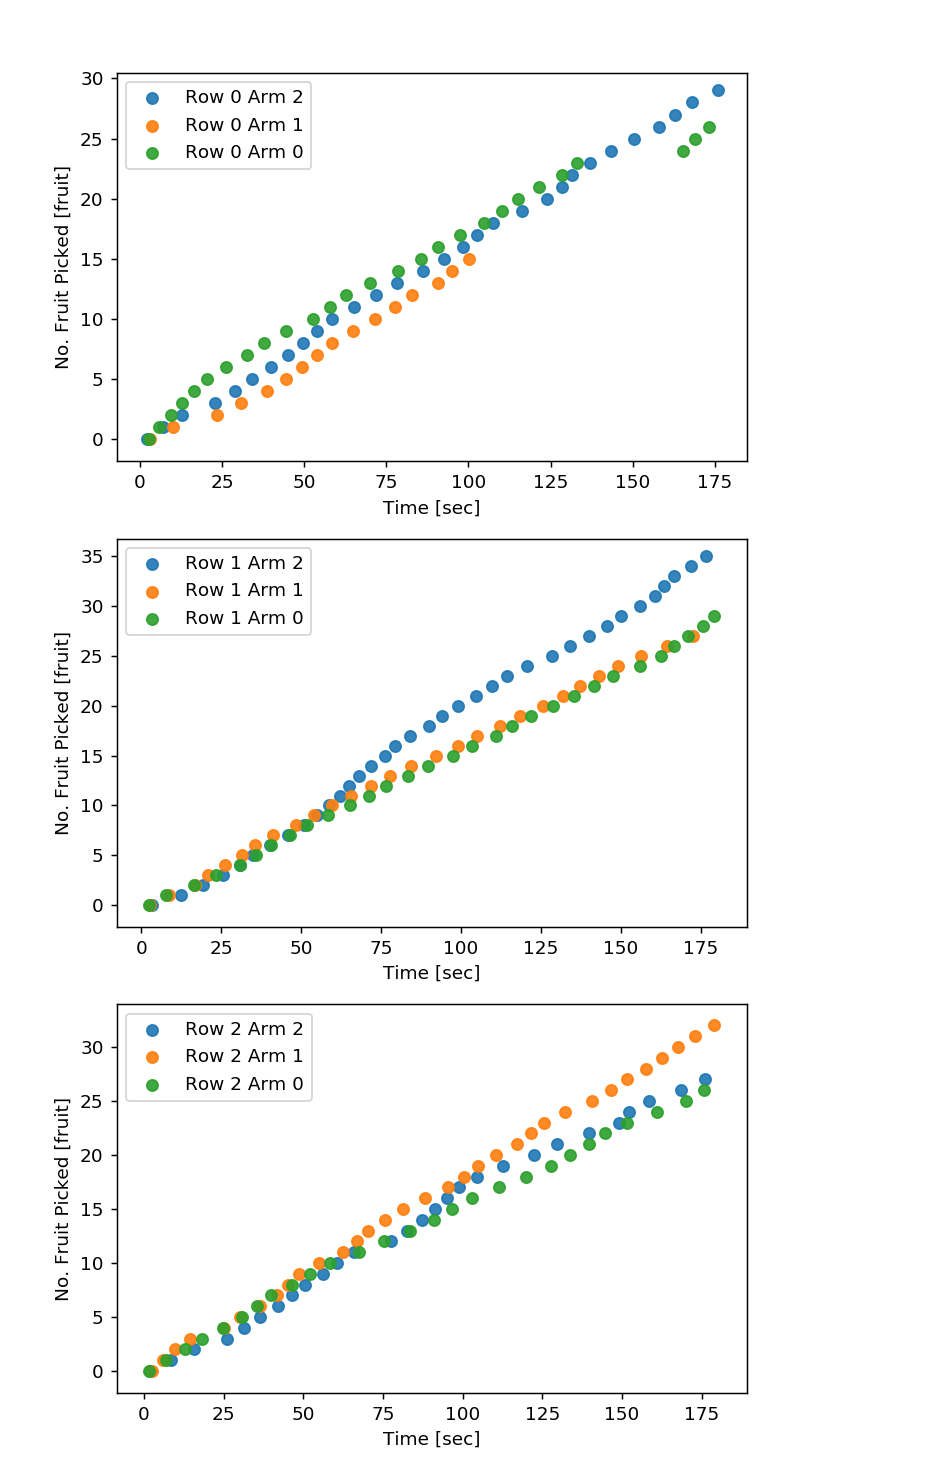

In [17]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples    = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [18]:
# analyze the % time each arm is in each state 
idle = 0.
picking = 0.
retracting = 0.
unloading = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
        
        if arm_num[1] == 0:
            idle += 1
        elif arm_num[1] == 1:
            picking += 1
        elif arm_num[1] == 2:
            retracting += 1
        elif arm_num[1] == 3:
            unloading += 1
        
    state_step += 1
        
idle_arm = 0.
pick_arm = 0.
retr_arm = 0.
unlo_arm = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot = []
pick_plot = []
retr_plot = []
unlo_plot = []


# for each arm
for i in range(9):
    for x in state_data[i]:
        if x == 0:
            idle_arm += 1
        elif x == 1:
            pick_arm += 1
        elif x == 2:
            retr_arm += 1
        elif x == 3:
            unlo_arm += 1
    
    total = idle_arm + pick_arm + retr_arm + unlo_arm
    
    idle_plot.append(idle_arm)
    pick_plot.append(pick_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    idle_arm = 0.
    pick_arm = 0.
    retr_arm = 0.
    unlo_arm = 0.



In [18]:
# analyze the % time each arm is in each state 
idle       = 0.
pickingyz  = 0.
pickingx   = 0.
grabbing   = 0.
retracting = 0.
unloading  = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

# obtain the state for each arm
for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
        # get totals for each 
#         if arm_num[1] == 0:
#             idle      += 1
#         elif arm_num[1] == 1:
#             pickingyz += 1
#         elif arm_num[1] == 2:
#             pickingx  += 1
#         elif arm_num[1] == 3:
#             grabbing  += 1
#         elif arm_num[1] == 4:
#             retracting += 1
#         elif arm_num[1] == 5:
#             unloading += 1
        
    state_step += 1
        
idle_arm   = 0.
pickyz_arm = 0.
pickx_arm  = 0.
grab_arm   = 0.
retr_arm   = 0.
unlo_arm   = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot   = []
pickyz_plot = []
pickx_plot  = []
grab_plot   = []
retr_plot   = []
unlo_plot   = []


# for each arm take the state obtained using state_data, determine the state at each time point for each arm 
for i in range(tot_num_arms):
    for x in state_data[i]:
        if x == 0:
            idle_arm   += 1
        elif x == 1:
            pickyz_arm += 1
        elif x == 2:
            pickx_arm  += 1
        elif x == 3:
            grab_arm   += 1
        elif x == 4:
            retr_arm   += 1
        elif x == 5:
            unlo_arm   += 1
    
    # add them all together so that percentages can be calculated
    total = idle_arm + pickyz_arm + pickx_arm + grab_arm + retr_arm + unlo_arm
    
    # get the total amount of time all arms spent in each state
    idle       += idle_arm
    pickingyz  += pickyz_arm
    pickingx   += pickx_arm
    grabbing   += grab_arm
    retracting += retr_arm
    unloading  += unlo_arm
    
    # append the current arm's data to the plotting list
    idle_plot.append(idle_arm)
    pickyz_plot.append(pickyz_arm)
    pickx_plot.append(pickx_arm)
    grab_plot.append(grab_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    # used to detemine which row corresponds to the specific arm
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    # reset for the next run
    idle_arm = 0.
    pick_arm = 0.
    retr_arm = 0.
    unlo_arm = 0.



In [19]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


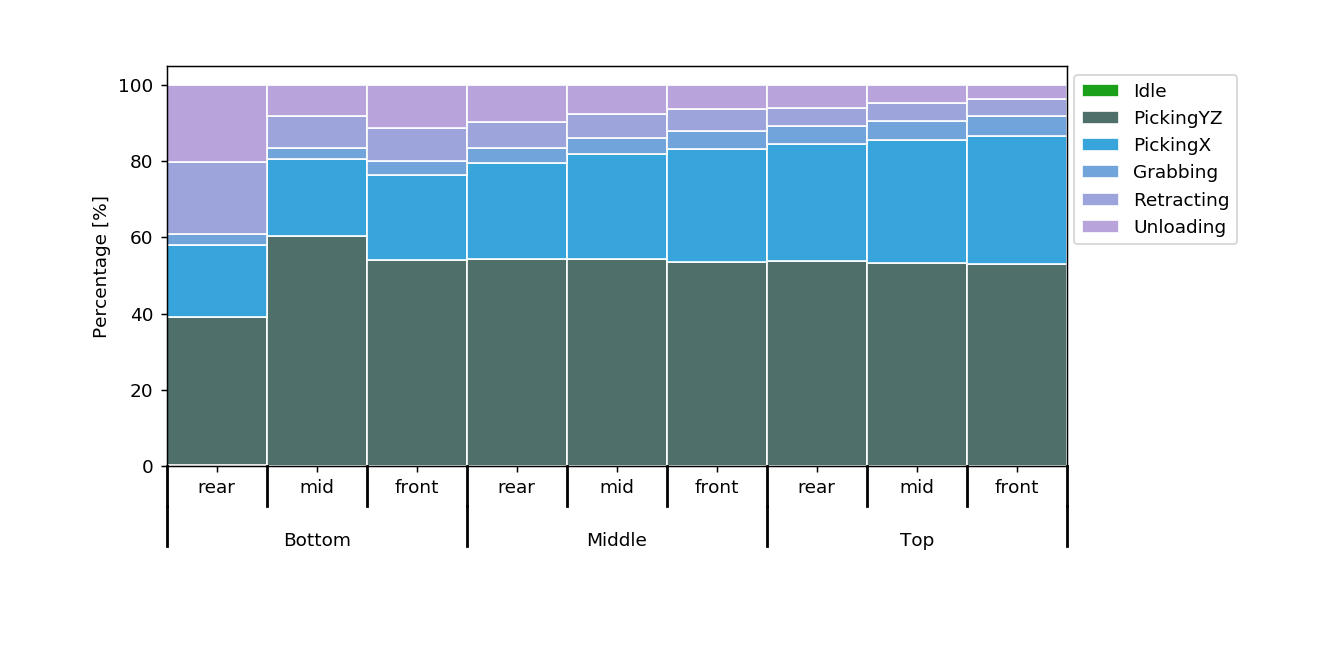

In [20]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(idle_plot, pickyz_plot, pickx_plot, grab_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for pickingyz state
per_pickyz = [i / j * 100 for  i,j in zip(pickyz_plot, totals)]
# Create the percentage of the total steps for pickingx state
per_pickx = [i / j * 100 for  i,j in zip(pickx_plot, totals)]
# Create the percentage of the total steps for grabbing state
per_grab = [i / j * 100 for  i,j in zip(grab_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#019600',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickyz, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='PickingYZ', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3C5F5A', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickx, 
       # with per_idle
       bottom=[i+j for i,j in zip(per_idle, per_pickyz)], 
       # labeled 
       label='PickingX', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#219AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_grab, 
       # with per_idle
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pickyz, per_pickx)], 
       # labeled 
       label='Grabbing', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#619AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(per_idle, per_pickyz, per_pickx, per_grab)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#919AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(per_idle, per_pickyz, per_pickx, per_grab, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#B19AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [86]:
# total values 
idle_all = idle*dt
pickyz_all = pickingyz*dt
pickx_all = pickingx*dt
grab_all = grabbing*dt
retract_all = retracting*dt
unload_all = unloading*dt

print("total time spent idle for all arms:", idle_all, "sec")
print("total time spent picking in yz axis for all arms:", pickyz_all, "sec")
print("total time spent picking in x axis for all arms:", pickx_all, "sec")
print("total time spent grabbing fruit for all arms:", grab_all, "sec")
print("total time spent retracting for all arms:", retract_all, "sec")
print("total time spent unloading for all arms:", unload_all, "sec")

total_time = (idle_all + pickyz_all + pickx_all + grab_all + retract_all + unload_all) # / (num_arms*num_row_arms)

print("total time all arms:", total_time, "sec") 
print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle    = (idle_all / total_time) * 100
percent_pickyz  = (pickyz_all / total_time) * 100
percent_pickx   = (pickx_all / total_time) * 100
percent_grab    = (grab_all / total_time) * 100
percent_retract = (retract_all / total_time) * 100
percent_unload  = (unload_all / total_time) * 100

print("")
print("For all arms:")
print("% time idle:              ", percent_idle)
print("")
print("% time picking in yz:     ", percent_pickyz, "and % time picking in x", percent_pickx)
print("% time grabbing the fruit:", percent_grab)
print("total percent picking:    ", percent_pickyz+percent_pickx+percent_grab)
print("")
print("% time retracting:        ", percent_retract, "% time unloading:", percent_unload)

total time spent idle for all arms: 3.33 sec
total time spent picking in yz axis for all arms: 3442.82 sec
total time spent picking in x axis for all arms: 1409.04 sec
total time spent grabbing fruit for all arms: 220.16 sec
total time spent retracting for all arms: 274.26 sec
total time spent unloading for all arms: 318.40000000000003 sec
total time all arms: 5668.01 sec
Which totals internal simulator seconds multiplied by number of arms

For all arms:
% time idle:               0.05875077849192221

% time picking in yz:      60.74124781007797 and % time picking in x 24.859518596473894
% time grabbing the fruit: 3.884255673507986
total percent picking:     89.48502208005985

% time retracting:         4.838735288046422 % time unloading: 5.617491853401812


In [21]:
# Calculate how many goals wer given to each arm and how many of those were reached
for rows in range(num_row):
    for count in range(num_arms):
        given = a[rows, count].goals_given
        reached = a[rows, count].reached_goals
        percent_reached = (reached / given) * 100
        
        print("For arm", count, "row", rows)
        print("Number of goals given:", given, "number of goals reached:", reached)
        print("Percent reached goals:", percent_reached, "%")
        print("")

For arm 0 row 0
Number of goals given: 36 number of goals reached: 27
Percent reached goals: 75.0 %

For arm 1 row 0
Number of goals given: 37 number of goals reached: 16
Percent reached goals: 43.24324324324324 %

For arm 2 row 0
Number of goals given: 41 number of goals reached: 30
Percent reached goals: 73.17073170731707 %

For arm 0 row 1
Number of goals given: 36 number of goals reached: 30
Percent reached goals: 83.33333333333334 %

For arm 1 row 1
Number of goals given: 35 number of goals reached: 28
Percent reached goals: 80.0 %

For arm 2 row 1
Number of goals given: 38 number of goals reached: 36
Percent reached goals: 94.73684210526315 %

For arm 0 row 2
Number of goals given: 37 number of goals reached: 27
Percent reached goals: 72.97297297297297 %

For arm 1 row 2
Number of goals given: 40 number of goals reached: 33
Percent reached goals: 82.5 %

For arm 2 row 2
Number of goals given: 43 number of goals reached: 28
Percent reached goals: 65.11627906976744 %



num runs 18000


<IPython.core.display.Javascript object>


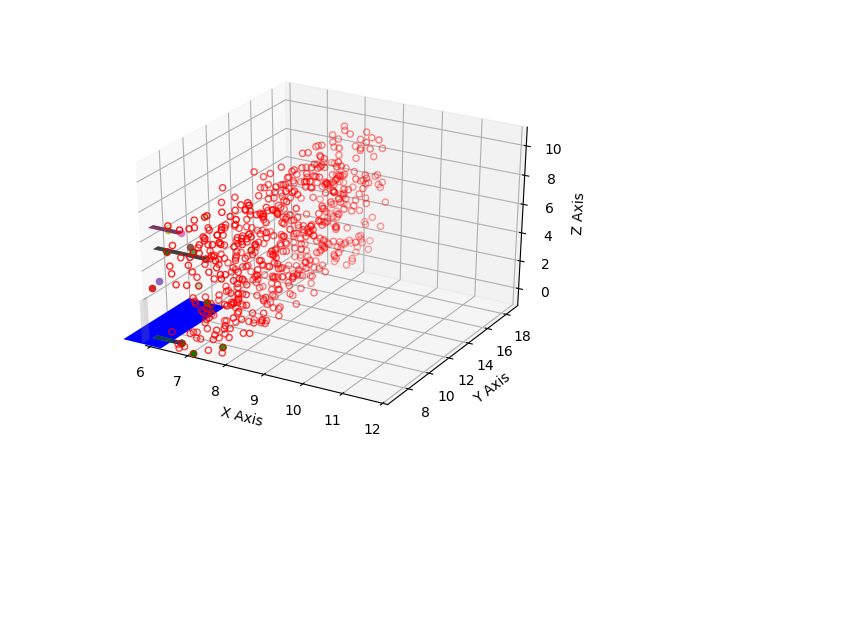

In [ ]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_zlim(-1, 11)
        
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [24]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0: 
        miss += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        
# should plot the three different groups to see where they are

        
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

Total missed fruit: 91
Total scheduled, but not picked fruit: 256
Total picked fruit: 253

They add up to: 600
Total unpicked fruit: 347
